# Семинар 4: Neural Radiance Field
## Вступление
В deep learning for 3D есть множество задач: часть из них перекликается с задачами на картинках (классификация, детекция), часть специфичны для области (structure-from-motion, novel view synthesis). Сегодня на занятии мы рассмотрим архитектуру NeRF, которая решает задачу novel view synthesis.

Постановка этой задачи такая:
1. Данные: набор фотографий объекта с разных ракурсов с известными углами съёмки ($\theta$, $\phi$)
2. Цель: научиться генерировать изображение с нового угла ($\theta$, $\phi$), которого не было в обучающей выборке

Решать задачу будем так:
1. Для каждого изображения из датасета
    - Проходимся по всем пикселям, через каждый пиксель "пропускаем луч" из камеры, семплим на нём n точек в пределах сцены
        - Для всех точек на луче полносвязными сетками предсказываем цвет и плотность, агрегируем их при помощи Монте-Карло для получения цвета пикселя ((x, y, z, $\theta$, $\phi$) -> RGB, $\sigma))
2. Сгенерированную картинку попиксельно сравниваем с картинкой из датасета, считаем MSE

Семинар отчасти позаимствован из [курса ШАД](https://github.com/yandexdataschool/deep_vision_and_graphics)

**Важно.** Код в ноутбуке исполняется долго. Лучше сразу его запустить.

Видео для затравочки:

In [1]:
from IPython.display import HTML

HTML(
    """
    <video alt="nerf_vid" width="500" controls>
        <source src="http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/website_renders/colorspout_200k_rgb.mp4" type="video/mp4">
    </video>
"""
)

### Скачиваем данные, импортим библиотеки

In [2]:
# !mkdir -p data
# !cd data
# !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
# !unzip nerf_example_data.zip
# !cd ..
# !wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py
# !mv nerf-helper.py nerf_helper.py

In [3]:
# !pip install imageio-ffmpeg

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from nerf_helper import *
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings("ignore")

## 1. Volume Rendering
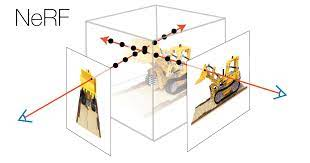

В этом занятии мы не будем заниматься созданием механизма объемного рендера объектов, но для общего понимания происходящего, надо слегка погрузиться в специфику.

Вспоминаем лекцию.

Запускаем лучи из камеры через пиксели в сторону сцены. Мы рендерим цвет всех лучей, проходящих через сцену, используя *объемный рендеринг*. Для начала вводим **функцию луча**: $r(t) = o + t * d$, где $o$ и $d$ — стартовая точка луча камеры и направление света соответственно, $t$ — координата вдоль направления луча. По сути, это векторное уравнение прямой в пространстве.

Дальше рассматриваем две функции (по умолчанию считаем, что они задают наше пространство, в том числе поверхности):

1. **Производная пространственной плотности** $\sigma(x)$.

Может быть интерпретирована как распределение плотности вероятности окончания луча в точке x. Вообще говоря, в случае непрозрачной поверхности это будет [дельта-функция](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Dirac_distribution_PDF.svg/650px-Dirac_distribution_PDF.svg.png). Интеграл от этой штуки — это вероятность наткнуться на что-то видимое. В нашем случае нам понадобится функция $T(t)$:
$$T(t)=\exp \left(-\int_{t_{n}}^{t} \sigma({r}(s)) d s\right).$$
    
$T$ вернет нам, наоборот, что-то похожее на вероятность того, что луч **не наткнулся на объект**.

2. **Функция цвета** $c(r)$.
Возвращает цвет для конкретной точки в пространстве и для конкретного луча. То есть при расчете нужно знать: луч $r(t)$, заданный $o$ и $d$; точку $t$ на луче, для которой хотим получить цвет.

Теперь соберем воедино все компоненты:  
Цвет, который получит камера для луча, заданного точкой $o$ и вектором света $d$ в пределах (координаты вдоль луча) от $t_n$ до $t_f$, равен интегрированной производной пространственной плотности по лучу с условием того, что луч до этого не натыкался на видимые объекты:

$$C(\mathbf{r})=\int_{t_{n}}^{t_{f}} T(t) \cdot  \sigma({r}(t)) \cdot {c}({r}(t))  dt,$$ 

*Совсем упрощенно: луч идет по пространству и аккумулирует цвета видимых объектов*


**Q: Когда интеграл обратится в ноль?**
**A:** Когда оба предела интегрирования будут лежать внутри объекта, или же весь интервал интегрирования будет лежать за пределами объекта


Проблема данной задачи состоит в подсчете этого интеграла. Как вариант решения, будем семплировать точки на луче из равномерного распределения и считать численно.

![image](https://user-images.githubusercontent.com/20357655/144260820-69d736bc-3dfb-4124-ac84-29d2e5fb7d05.png)

In [5]:
class VolumeRenderer(nn.Module):
    def __init__(
        self,
        train_radiance_field_noise_std=0.0,
        val_radiance_field_noise_std=0.0,
        white_background=False,
        attenuation_threshold=1e-3,
        device="cuda",
    ):
        super().__init__()
        self.train_radiance_field_noise_std = train_radiance_field_noise_std
        self.val_radiance_field_noise_std = val_radiance_field_noise_std
        self.attenuation_threshold = attenuation_threshold
        self.use_white_bkg = white_background
        epsilon = torch.tensor([1e10]).to(device)
        epsilon.requires_grad = False
        self.register_buffer("epsilon", epsilon)

    def forward(self, radiance_field, depth_values, ray_directions):
        """
        Perform volume rendering by computing the output of NeRF model ('radiance_field')
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3)
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
        """

        if self.training:
            radiance_field_noise_std = self.train_radiance_field_noise_std
        else:
            radiance_field_noise_std = self.val_radiance_field_noise_std

        # distance between adjacent samples points.
        deltas = torch.cat(
            (
                depth_values[..., 1:] - depth_values[..., :-1],
                self.epsilon.expand(depth_values[..., :1].shape),
            ),
            dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        noise = 0.0
        if radiance_field_noise_std > 0.0:
            noise = (
                torch.randn(
                    radiance_field[..., 3].shape,
                    dtype=radiance_field.dtype,
                    device=radiance_field.device,
                )
                * radiance_field_noise_std
            )  # (ray_count, num_samples)

        sigmas = torch.nn.functional.softplus(radiance_field[..., 3] + noise)

        # Originally  alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise))
        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # T_i = cumulative-product(j=1,j=(i-1))(1 - alpha_j)
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        # weight_i = T_i * alpha_i
        weights = alpha * T_i  # (ray_count, num_samples)
        # (ray_count, num_samples)
        mask_weights = (T_i > self.attenuation_threshold).float()
        rgb_map = weights[..., None] * rgb  # (ray_count, num_samples, 3)

        # sum over rgb value of each sample points (sum_over R,sum_over G, sum_over B) along the ray
        rgb_map = rgb_map.sum(dim=-2)  # (ray_count, 3)

        # sum over weight of each ray
        acc_map = weights.sum(dim=-1)  # (ray_count, )

        depth_map = (weights * depth_values).sum(dim=-1)  # (ray_count, )

        if self.use_white_bkg:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map

## NeRF: Implicit 3d scene representation

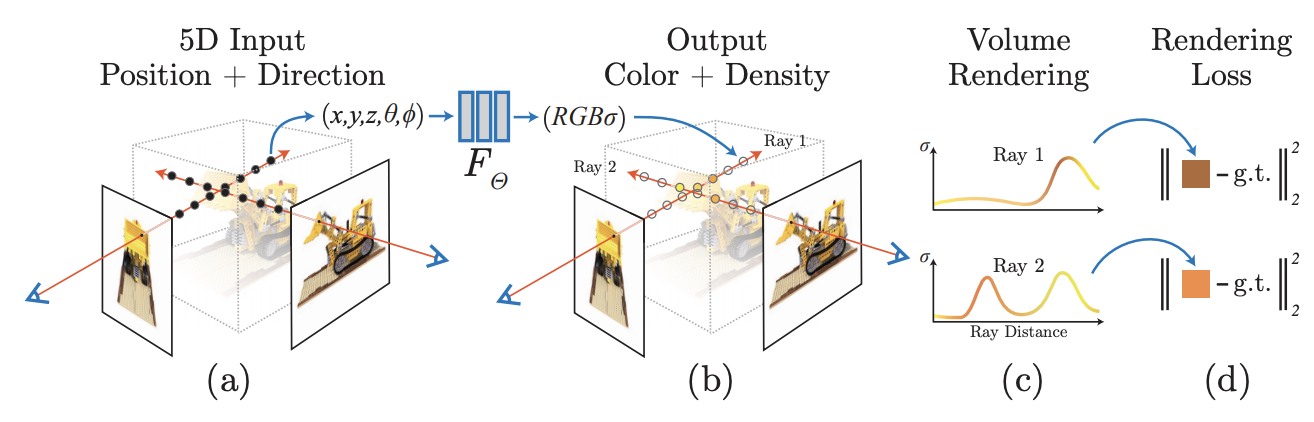

**Nerf Diagram**

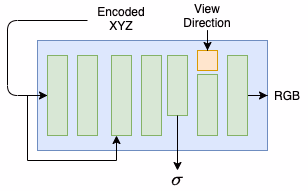

Наша цель — предсказывать две функции: $\sigma$ и $c$. Сигма для нас зависит только от конкретной точки, а цвет зависит от луча и точки.

На вход сети подаём координаты точки со сцены и угол, с которого смотрим на сцену. Сначала координаты преобразуются 8 полносвязными слоями, на выходе которых мы получаем $\sigma$ и 256-мерный вектор фичей, отображающий геометрию и не зависящий от взгляда цвет (**view-independent**). Затем этот вектор конкатенируется с лучом камеры (view direction) и передается в дополнительный полносвязный слой, который даст нам зависимый от направления луча цвет (**view-dependent**)

In [6]:
from IPython.display import HTML

HTML(
    """
    <video alt="nerf_view" width="1000" controls>
        <source src="http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/website_renders/viewdirs_website_bww.mp4" type="video/mp4">
    </video>
"""
)

### Harmonic embeddings

Одна из главных идей NeRF — использование harmonic embeddings.

$$\gamma(x, L)=\left[\sin (\pi x), \cos (\pi x), \sin (2 \pi x), \cos (2 \pi x), \ldots, \sin \left(2^{L-1} \pi x\right), \cos \left(2^{L-1} \pi x\right)\right]$$

$L$ — это гиперпараметр размерности. NeRF применяет уравнение на каждую координату, повышая тем самым размерность входных данных. Точка $(x, y, z)$  переходит в -> $3 + L * 3$ координат, которые мы скармливаем сети

**Q: Зачем?**
**A:** Сетям становится проще улавливать детализированные объекты

Почитать про это можно здесь: 
- https://bmild.github.io/fourfeat/
- https://vsitzmann.github.io/siren/



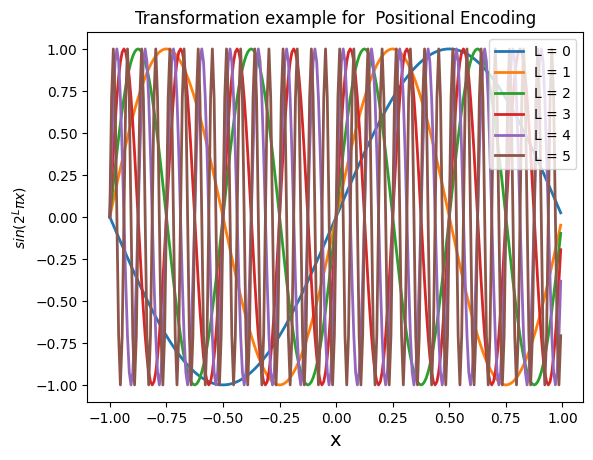

In [7]:
W = 256

x = np.linspace(0, W - 1, W)
x = (x * 1.0 / W) * 2 - 1

L = 6


for el in range(0, L):
    y = np.sin(2**el * np.pi * x)
    plt.plot(x, y, label=str("L = {}").format(el), linewidth=2)

plt.title("Transformation example for  Positional Encoding")
plt.xlabel("x", fontsize=14)
plt.ylabel("$sin(2^L \pi x$)", fontsize=10)
plt.legend(loc="upper right")
plt.savefig("sin.png", dpi=100)
plt.show()

In [8]:
!ls nerf_synthetic/lego

test   transforms_test.json   transforms_val.json
train  transforms_train.json  val


In [9]:
root = "nerf_synthetic/lego"
main = "transforms_test.json"

In [10]:
ex_dataset = BlenderDataset("nerf_synthetic/lego/", img_wh=[100, 100])
print(f"Number of pixels: {len(ex_dataset)}")

Number of pixels: 1000000


In [11]:
class Embedder(nn.Module):
    """
    Defines a function that embeds x to (x, sin(2^k x), cos(2^k x), ...)
    (Different from the paper, prepend input 'x' by default)
    Args:
        input_channels (int): number of input channels
        num_freqs (int): `L_d=4` for viewing direcion, `L_x=10` for 3D-coordinate
        log_scale (bool):
        First take power of 2 for 0 to 9 and then split equally (log_scale=False)
        or choose to generate 0-9 first and then take power of 2 separately
    """

    def __init__(
        self,
        input_channels,
        num_freqs,
    ):
        super().__init__()
        self.num_freqs = num_freqs
        self.input_channels = input_channels
        self.encode_fn = [torch.sin, torch.cos]
        self.output_channels = input_channels * (len(self.encode_fn) * num_freqs + 1)
        self.freq_bands = torch.linspace(1, 2 ** (num_freqs - 1), num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (ray_cnt, num_sample, self.in_channels)
        Outputs:
            out: (ray_cnt, num_sample, self.out_channels)
        """
        out = [x]
        for freq in self.freq_bands:
            for func in self.encode_fn:
                out += [func(freq * x)]

        return torch.cat(out, -1)

### NeRF implementation

In [12]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_channels_xyz=63, in_channels_dir=27, skips=[4]):
        """
        D: number of layers for density (sigma) encoder
        W: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super().__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(self.in_channels_xyz, W)
            elif i in skips:
                layer = nn.Linear(self.in_channels_xyz + W, W)
            else:
                layer = nn.Linear(W, W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
            nn.Linear(self.in_channels_dir + W, W // 2),
            nn.ReLU(True),
        )

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(nn.Linear(W // 2, 3), nn.Sigmoid())

    def forward(self, x, sigma_only=False):
        """
        Encodes input (xyz+dir) to rgb+sigma (not ready to render yet).
        For rendering this ray, please see Renderer.py
        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
            sigma_only: whether to infer sigma only. If True,
                        x is of shape (B, self.in_channels_xyz)
        Outputs:
            if sigma_only:
                sigma: (B, 1) sigma
            else:
                out: (B, 4), rgb and sigma
        """
        if not sigma_only:
            input_xyz, input_dir = torch.split(
                x, [self.in_channels_xyz, self.in_channels_dir], dim=-1
            )
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)
        out = torch.cat([rgb, sigma], dim=-1)
        return out

In [13]:
class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.params = hparams

        self.num_workers = 10
        self.loss = nn.MSELoss(reduction="mean")

        self.embedder_xyz = Embedder(
            input_channels=3,
            num_freqs=10,
        )

        self.embedder_dir = Embedder(
            input_channels=3,
            num_freqs=4,
        )
        self.sampler = RaySampleInterval(hparams["N_samples"], device=self.device)
        self.embeddings = {
            "xyz": self.embedder_xyz,
            "dir": self.embedder_dir,
        }

        self.models = NeRF(in_channels_xyz=hparams["in_feat"])
        self.img_wh = hparams["img_wh"]
        # rendering module
        self.volume_renderer = VolumeRenderer(
            train_radiance_field_noise_std=hparams["noise_std"],
            val_radiance_field_noise_std=0,
            white_background=hparams["white_back"],
            attenuation_threshold=1e-5,
            device=self.device,
        )

    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def forward(self, ray_batch):
        """Does a prediction for a batch of rays.
        Args:
            x: Tensor of camera rays containing position, direction and bounds.
        Returns: Tensor with the calculated pixel value for each ray.
        """

        def inference(
            model, embedder_xyz, xyz, embedder_dir, expanded_rays_dir, device
        ):
            """
            Helper function that performs model inference.
            Inputs:
                model: NeRF model (coarse or fine)
                embedder_xyz: embedding module for xyz
                xyz: (N_rays, N_samples_, 3) sampled positions
                    N_samples_ is the number of sampled points in each ray;
                                = N_samples for coarse model
                                = N_samples+N_importance for fine model
                embedder_dir: embedding module for direction
                expanded_rays_dir: (N_rays, N_samples, 3) :expanded ray directions
            Outputs:
                if sigma_only:
                    radience_field:(N_rays, N_samples, 1)
                else:
                    radience_field:(N_rays, N_samples, 3+1)
            """
            assert (
                xyz.shape[0] == expanded_rays_dir.shape[0]
            ), "Number of ray differ in coordinate and directions!"
            N_rays = xyz.shape[0]
            assert (
                xyz.shape[1] == expanded_rays_dir.shape[1]
            ), "Number of samples differ in coordinate and directions!"
            N_samples = xyz.shape[1]
            # Flatten the first two dimensions -> (N_rays * N_samples, 3)
            xyz_ = xyz.view(-1, 3)  # (N_rays*N_samples_, 3)
            expanded_rays_dir = expanded_rays_dir.contiguous()
            # (N_rays*N_samples_, 3)
            expanded_rays_dir_ = expanded_rays_dir.view(-1, 3)

            xyz_embedded = embedder_xyz(xyz_)  # (N_rays*N_samples_, 63)
            # (N_rays*N_samples_, 27)
            dir_embedded = embedder_dir(expanded_rays_dir_)

            xyzdir_embedded = torch.cat((xyz_embedded, dir_embedded), dim=-1).to(device)
            radiance_field = model(xyzdir_embedded)
            radiance_field = torch.reshape(radiance_field, (N_rays, N_samples, -1)).to(
                device
            )
            return radiance_field

        # both (N_rays, N_sample, 3)
        ray_origins, ray_directions = ray_batch[:, 0:3], ray_batch[:, 3:6]
        # both (N_rays, N_sample, 1)
        near, far = ray_batch[:, 6:7], ray_batch[:, 7:8]

        # Generating depth samples
        ray_count = ray_directions.shape[0]
        ray_depth_values = self.sampler(
            ray_count=ray_count,
            near=near,
            far=far,
            lindisp=self.params["lindisp"],
            perturb=self.params["perturb"],
        )
        # Samples across each ray (N_rays, N_sample, 3)
        ray_points = intervals_to_ray_points(
            ray_depth_values, ray_directions, ray_origins
        )

        # Expand rays to match batch size
        expanded_ray_directions = ray_directions[..., None, :].expand_as(ray_points)
        # Coarse inference
        coarse_radiance_field = inference(
            model=self.models,
            embedder_xyz=self.embedder_xyz,
            embedder_dir=self.embedder_dir,
            xyz=ray_points,
            expanded_rays_dir=expanded_ray_directions,
            device=self.device,
        )
        coarse_rgb = self.volume_renderer(
            coarse_radiance_field,
            ray_depth_values,
            ray_directions,
        )  # volume rendering

        return coarse_rgb

    def setup(self, stage):
        kwargs = {"root_dir": self.params["root_dir"], "img_wh": tuple(self.img_wh)}

        self.train_dataset = BlenderDataset(split="train", **kwargs)
        self.val_dataset = BlenderDataset(split="val", **kwargs)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(
            get_parameters(self.models), lr=5e-3, betas=(0.9, 0.999)
        )
        return [self.optimizer]

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            shuffle=True,
            num_workers=self.num_workers,
            batch_size=self.params["batch_size"],
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            shuffle=False,
            num_workers=self.num_workers,
            # validate one image (H*W rays) at a time
            batch_size=1,
            pin_memory=True,
        )

    def training_step(self, batch, batch_nb):
        rays, rgbs = batch["rays"], batch["rgbs"]

        results = self.forward(rays)
        loss = self.loss(results, rgbs)

        with torch.no_grad():
            psnr_coarse = psnr(self.loss(results, rgbs))

        self.log("train/loss", loss)
        self.log("train/psnr_coarse", psnr_coarse, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb):
        rays, rgbs = batch["rays"], batch["rgbs"]
        rays = rays.squeeze()  # (H*W, 3)
        rgbs = rgbs.squeeze()  # (H*W, 3)
        results = self.forward(rays)
        log = {"val_loss": self.loss(results, rgbs)}

        if batch_nb == 0:
            W, H = self.img_wh
            plt.subplot(121)
            plt.imshow(results.view(H, W, 3).cpu().numpy())
            plt.axis("off")
            plt.subplot(122)
            plt.imshow(rgbs.view(H, W, 3).cpu().numpy())
            plt.axis("off")
            plt.show()

        psnr_ = psnr(self.loss(results, rgbs))
        log["val_psnr"] = psnr_

        return log

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        mean_psnr = torch.stack([x["val_psnr"] for x in outputs]).mean()

        self.log("val/loss", mean_loss)
        self.log("val/psnr", mean_psnr, prog_bar=True)

### Training

In [14]:
args = {
    "batch_size": 2400,
    "noise_std": 0,
    "white_back": True,
    "lindisp": False,
    "perturb": True,
    "in_feat": 63,
    "img_wh": [150, 150],
    "root_dir": "nerf_synthetic/lego/",
    "N_samples": 64,
}

In [15]:
system = NeRFSystem(args)

In [16]:
torch.cuda.device_count()

1

In [17]:
epochs = 7
ckpt_path = None
trainer = Trainer(
    max_epochs=epochs,
    resume_from_checkpoint=ckpt_path,
    gpus=1,
    enable_model_summary=True,
    enable_progress_bar=True,
    num_sanity_val_steps=1,
    check_val_every_n_epoch=1,
    benchmark=False,
    profiler=None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | loss            | MSELoss           | 0     
1 | embedder_xyz    | Embedder          | 0     
2 | embedder_dir    | Embedder          | 0     
3 | sampler         | RaySampleInterval | 0     
4 | models          | NeRF              | 595 K 
5 | volume_renderer | VolumeRenderer    | 0     
------------------------------------------------------
595 K     Trainable params
0         Non-trainable params
595 K     Total params
2.383     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

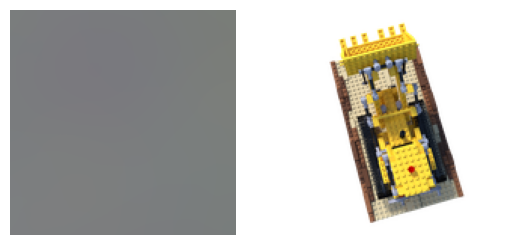

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

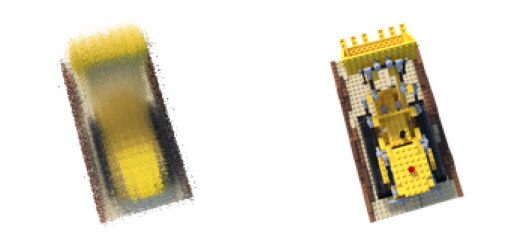

Validation: 0it [00:00, ?it/s]

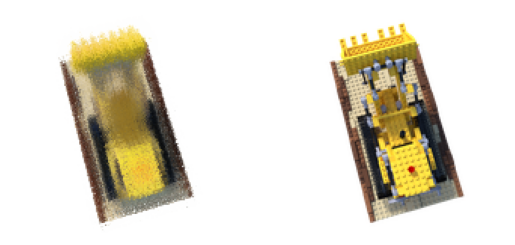

Validation: 0it [00:00, ?it/s]

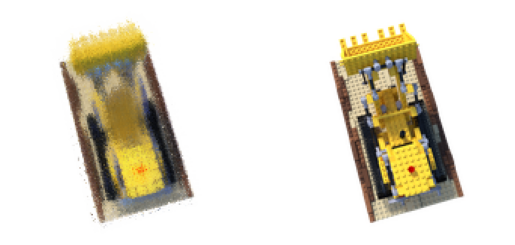

Validation: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


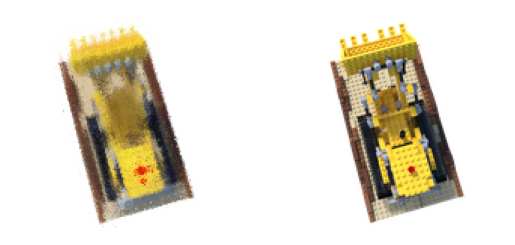

Validation: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


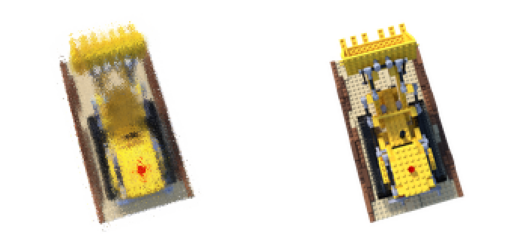

Validation: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


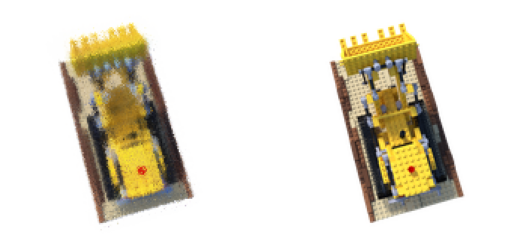

Validation: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


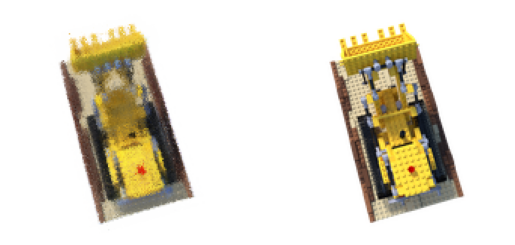

`Trainer.fit` stopped: `max_epochs=7` reached.


In [18]:
trainer.fit(system)

In [19]:
torch.save(system.models.state_dict(), "model.pt")

In [20]:
from base64 import b64encode

import imageio
from IPython.display import HTML


def show_vid(frames, path="video.mp4"):
    imageio.mimwrite(path, frames, fps=30, quality=7)
    mp4 = open(path, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(
        """
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
    """
        % data_url
    )

In [21]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]], dtype=torch.float
    )


def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor(
        [
            [1, 0, 0, 0],
            [0, torch.cos(phi), -torch.sin(phi), 0],
            [0, torch.sin(phi), torch.cos(phi), 0],
            [0, 0, 0, 1],
        ],
        dtype=torch.float,
    )


def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor(
        [
            [torch.cos(theta), 0, -torch.sin(theta), 0],
            [0, 1, 0, 0],
            [torch.sin(theta), 0, torch.cos(theta), 0],
            [0, 0, 0, 1],
        ],
        dtype=torch.float,
    )


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi / 180.0 * np.pi) @ c2w
    c2w = rot_theta(theta / 180.0 * np.pi) @ c2w
    c2w = (
        torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]).float()
        @ c2w
    )
    return c2w

In [22]:
N_SAMPLES = 32
H = W = 150
frames = []
system = system.cuda()
for th in tqdm(np.linspace(0.0, 360.0, 120, endpoint=False)):
    c2w = pose_spherical(th, -30.0, 4.0)

    rays_o, rays_d = get_rays_with_dir(system.train_dataset.dir_cam, c2w[:3, :4])

    near = 2.0
    far = 6.0
    rays = torch.cat(
        [
            rays_o,
            rays_d,
            near * torch.ones_like(rays_o[:, :1]),
            far * torch.ones_like(rays_o[:, :1]),
        ],
        1,
    )  # (H*W, 8)

    with torch.no_grad():
        rgb = system(rays.cuda())
        # rgb = render_rays(model, rays_o.cuda(), rays_d.cuda(), near=2., far=6., n_samples=N_SAMPLES)
    # frames.append(())
    frames.append(
        (255 * np.clip(rgb.view(H, W, 3).cpu().numpy(), 0, 1)).astype(np.uint8)
    )

  0%|          | 0/120 [00:00<?, ?it/s]

In [23]:
show_vid(frames)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (150, 150) to (160, 160) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x571af80] Warning: data is not aligned! This can lead to a speed loss


In [24]:
del frames